<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula02d_custo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

def criaDatasetBidimensionalBinário(n=20, slop=[2, 1], intercept=0.4, dummy_features=0):
    X = np.random.uniform(size=(n,dummy_features+2))
    AUX = np.multiply(X[:,:2], slop)-[0, intercept]
    y = np.array(AUX[:,0]>AUX[:,1], dtype=int)*2-1
    return X, y

slop = [2, 1]
intercept = -0.4
Xtr, ytr = criaDatasetBidimensionalBinário(n=20, slop=slop, intercept=intercept)
Xtr, ytr

(array([[0.9017603 , 0.26589714],
        [0.02511399, 0.79765592],
        [0.73609156, 0.805371  ],
        [0.02388762, 0.94563698],
        [0.21489164, 0.15862566],
        [0.27911517, 0.01995365],
        [0.26984674, 0.28462325],
        [0.38558271, 0.87923653],
        [0.04384305, 0.20876037],
        [0.92144348, 0.12620031],
        [0.43746836, 0.24273118],
        [0.30686181, 0.88284789],
        [0.04457498, 0.50421745],
        [0.11117946, 0.40683645],
        [0.07169503, 0.18867925],
        [0.56030905, 0.2880878 ],
        [0.59125866, 0.01127595],
        [0.83864678, 0.4005319 ],
        [0.34354074, 0.87742137],
        [0.58412346, 0.1373926 ]]),
 array([ 1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1,
         1, -1,  1]))

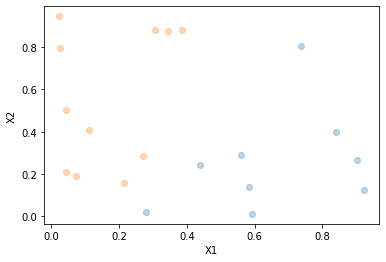

In [ ]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

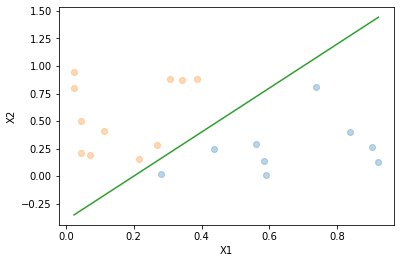

In [ ]:
def plotaHiperplanoDatasetBidimensional(X, y, vetor, intercept=0):
    """
    Plota um dataset bidimensional com um hiperplano definido por um
    vetor e o valor em que este vetor intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array(slop) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, ytr, vetor_hyperplano, intercept)

In [ ]:
def sign(a):
  return (a >= 0) * 2 - 1

In [ ]:
def accuracy(yactual, ypred):
  return sum(yactual == ypred)/len(yactual)

In [ ]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
  @abstractstaticmethod
  def custo(y, ypred):
    pass
  @abstractstaticmethod
  def gradiente(y, ypred, X):
    pass
  
class WidrowHoff(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum((y - ypred)**2)
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - ypred)

class SmootheSurrogate(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    errosmarginais = (y * ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return X.T @ ymarginais


In [ ]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05, 
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=X.shape[1])
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

1.0
[-0.6611722   2.51621583 -0.96348837]


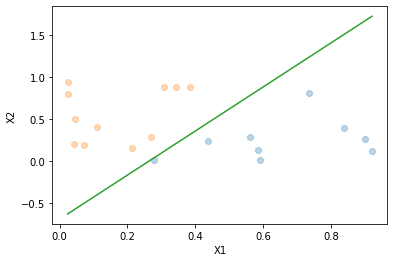

0.976


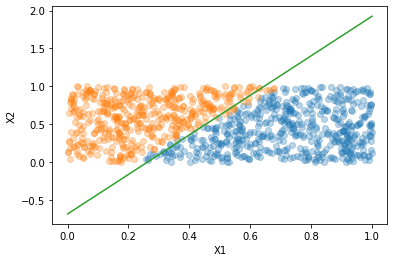

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import random

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
     self.w = None
     self.activation = sign
     self.training_algorithm = training_algorithm

  def fit(self, X, y):
    Xb = include_bias(X)
    self.w = self.training_algorithm.getW(Xb, y)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    ypred = self.activation(a)
    return ypred

perceptron = Perceptron()
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)
plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
plt.show()
Xte, yte = criaDatasetBidimensionalBinário(n=1000, slop=slop, intercept=intercept)
print(accuracy(yte, perceptron.predict(Xte)))
plotaDatasetBidimensional(Xte, yte)
plotaHiperplanoDatasetBidimensional(Xte, yte, perceptron.w[1:], perceptron.w[0])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

1.0
[-0.18203166  1.33460495 -0.80578625]


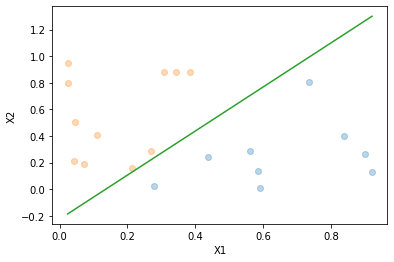

0.971


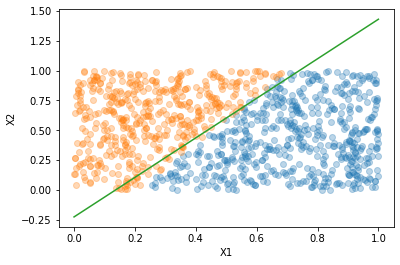

In [ ]:
perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=SmootheSurrogate()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)
plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
plt.show()
print(accuracy(yte, perceptron.predict(Xte)))
plotaDatasetBidimensional(Xte, yte)
plotaHiperplanoDatasetBidimensional(Xte, yte, perceptron.w[1:], perceptron.w[0])

1.0
[-0.98288473  5.62568481 -2.54981088]


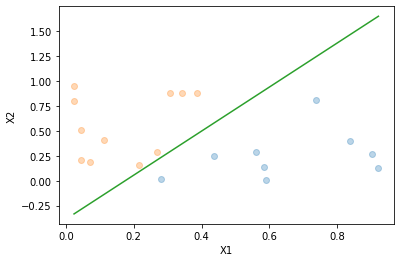

0.957


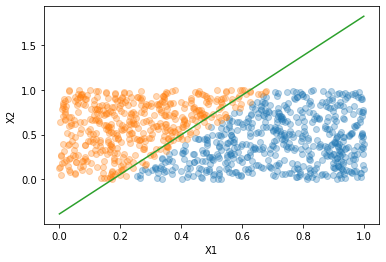

In [ ]:
perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=HingeLoss()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)
plotaHiperplanoDatasetBidimensional(Xtr, ytr, perceptron.w[1:], perceptron.w[0])
plt.show()
print(accuracy(yte, perceptron.predict(Xte)))
plotaDatasetBidimensional(Xte, yte)
plotaHiperplanoDatasetBidimensional(Xte, yte, perceptron.w[1:], perceptron.w[0])